# Tensorflow DNN - add dropout

## import package

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

## prepare dataset examples

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ..., 
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


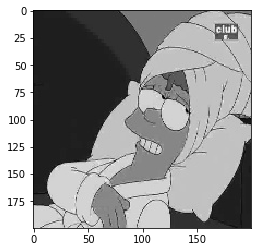

In [3]:
img_src = '/data/examples/simpson_preproc/'

simpson_img = pd.read_csv(img_src + 'simpson_img_list.csv')
print(simpson_img.head())

img = cv2.imread(img_src + simpson_img.img.iloc[0], 0)
plt.imshow(img, cmap='gray')

simpson_img = simpson_img[simpson_img.img.str.contains('simpson')] # filter data

simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix() # transform y to one-hot encoder format
print(simpson_y) 

## split dataset to training data and testing data

In [4]:
x_train_list, x_test_list, y_train, y_test = train_test_split(simpson_img, simpson_y, test_size=0.1)  ## 將 input_x 和 input_y 各自區分成 training data 和 testing data

## record the dim of img ##
img = cv2.resize(img, (50,50))
img = img.flatten()

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=(len(x_train_list), img.shape[0]), 
            testing_shape=(len(x_test_list), img.shape[0])))
print('y_true shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, 
            testing_shape=y_test.shape))

input_data shape: training (6546, 2500) ; testing (728, 2500)
y_true shape: training (6546, 6) ; testing (728, 6)


## define image generator

In [5]:
from sklearn.utils import shuffle 

def simpson_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            dir_img = img_src + x.img.iloc[i]
            img = cv2.imread(dir_img, 0)
            img = cv2.resize(img, (50,50))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

def simpson_test_batch_generator(x, shape):
    x_test = np.array([]).reshape((0, shape))
    for i in range(len(x)):
        dir_img = img_src + x.img.iloc[i]
        img = cv2.imread(dir_img, 0)
        img = cv2.resize(img, (50,50))
        x_test = np.row_stack([x_test, img.flatten()])
    x_test /= 255.      
    return x_test

x_test = simpson_test_batch_generator(x_test_list, img.shape[0])

# create graph

In [6]:
#### define placeholder ####
tf.reset_default_graph() ## 重新 build graph 需要跑這行

input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, img.shape[0]],
                           name='input_data')

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true')

drp_rate = tf.placeholder(dtype=tf.float32, name = 'dropout')
is_train = tf.placeholder(dtype=tf.bool)
#### define variables(weight/bias) ####
x1 = tf.layers.dense(input_data, 
                     256, 
                     activation=tf.nn.relu, 
                     name='hidden1')
x1 = tf.layers.dropout(inputs=x1, rate=drp_rate, training=is_train)

x2 = tf.layers.dense(x1, 
                     128, 
                     activation=tf.nn.relu, 
                     name='hidden2')
x2 = tf.layers.dropout(inputs=x2, rate=drp_rate, training=is_train)

x3 = tf.layers.dense(x2, 
                     64, 
                     activation=tf.nn.relu, 
                     name='hidden3')
x3 = tf.layers.dropout(inputs=x3, rate=drp_rate, training=is_train)

out = tf.layers.dense(x3, y_train.shape[1], name='output')

y_pred = tf.nn.softmax(out)

#### calculate loss ####
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=out))

#### optimize variables ####
opt = tf.train.AdamOptimizer(learning_rate=0.001)

update = opt.minimize(loss)
    
# grad = opt.compute_gradients(loss)
# update = opt.apply_gradients(grad)

# run session

In [7]:
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score

epoch = 100 #100
bs = 32
update_per_epoch = 100
g_train_loss, g_valid_loss = [], []
g_train_acc, g_valid_acc = [], []

for drop_rate in [0.0, 0.05, 0.1, 0.2, 0.4]:
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    tr_loss = list()
    te_loss = list()
    tr_acc = list()
    te_acc = list()
    train_gen = simpson_train_batch_generator(x_train_list, y_train, bs, img.shape[0])

    print('start modelling!')

    for i in range(epoch):

        #### calculate training loss & update variables ####
        training_loss = 0
        training_acc = 0
        bar = tqdm(range(update_per_epoch))
        for j in bar:

            x_batch, y_batch = next(train_gen)

            tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={
                input_data:x_batch,
                y_true:y_batch,
                drp_rate: drop_rate,
                is_train: True
            })

            training_loss += training_loss_batch

            training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
            training_acc += training_acc_batch

            if j % 5 == 0:
                pass
                #bar.set_description('loss: %.4g' % training_loss_batch)

        ###
        training_loss /= update_per_epoch
        training_acc /= update_per_epoch

        #### calculate testing data loss ####
        te_pred, testing_loss = sess.run([y_pred, loss], feed_dict={
            input_data:x_test,
            y_true:y_test,
            drp_rate: 0.0,
            is_train: False
        })

        testing_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(te_pred, axis=1))

        tr_loss.append(training_loss)
        te_loss.append(testing_loss)
        tr_acc.append(training_acc)
        te_acc.append(testing_acc)

        print('epoch {epochs}: training loss {training_loss} ; testing loss {testing_loss}'.format(
                epochs=(i+1), 
                training_loss=training_loss,
                testing_loss=testing_loss))
        
    sess.close()
    g_train_loss.append(tr_loss)
    g_valid_loss.append(te_loss)
    g_train_acc.append(tr_acc)
    g_valid_acc.append(te_acc)


  0%|          | 0/100 [00:00<?, ?it/s]

start modelling!


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 1: training loss 1.624916250705719 ; testing loss 1.557043194770813


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 2: training loss 1.5713791060447693 ; testing loss 1.5672247409820557


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 3: training loss 1.5681852579116822 ; testing loss 1.5701608657836914


  1%|          | 1/100 [00:00<00:18,  5.49it/s]

epoch 4: training loss 1.5269845068454742 ; testing loss 1.5200990438461304


  1%|          | 1/100 [00:00<00:16,  5.96it/s]

epoch 5: training loss 1.495057224035263 ; testing loss 1.5086947679519653


  1%|          | 1/100 [00:00<00:16,  6.18it/s]

epoch 6: training loss 1.5206759011745452 ; testing loss 1.5245475769042969


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 7: training loss 1.505993674993515 ; testing loss 1.4964301586151123


  1%|          | 1/100 [00:00<00:14,  6.93it/s]

epoch 8: training loss 1.4773846650123597 ; testing loss 1.5035535097122192


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 9: training loss 1.467459293603897 ; testing loss 1.498865008354187


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 10: training loss 1.4785780084133149 ; testing loss 1.5111888647079468


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 11: training loss 1.4462893283367158 ; testing loss 1.5002169609069824


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 12: training loss 1.4521903955936433 ; testing loss 1.4920576810836792


  1%|          | 1/100 [00:00<00:15,  6.29it/s]

epoch 13: training loss 1.4360498404502868 ; testing loss 1.4921051263809204


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 14: training loss 1.4498443818092346 ; testing loss 1.4819892644882202


  1%|          | 1/100 [00:00<00:18,  5.26it/s]

epoch 15: training loss 1.4174204897880553 ; testing loss 1.5013171434402466


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 16: training loss 1.4195545601844788 ; testing loss 1.5173817873001099


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 17: training loss 1.4121290969848632 ; testing loss 1.5311753749847412


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 18: training loss 1.4279799449443817 ; testing loss 1.5224993228912354


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 19: training loss 1.409189019203186 ; testing loss 1.4922243356704712


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

epoch 20: training loss 1.377587298154831 ; testing loss 1.4948838949203491


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

epoch 21: training loss 1.351904215812683 ; testing loss 1.5099095106124878


  1%|          | 1/100 [00:00<00:16,  6.10it/s]

epoch 22: training loss 1.3627391159534454 ; testing loss 1.4916722774505615


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 23: training loss 1.3563029384613037 ; testing loss 1.452426791191101


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 24: training loss 1.3571390974521638 ; testing loss 1.5134567022323608


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 25: training loss 1.3274349176883697 ; testing loss 1.458349585533142


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

epoch 26: training loss 1.3165094417333603 ; testing loss 1.4863263368606567


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 27: training loss 1.3148830330371857 ; testing loss 1.514365553855896


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 28: training loss 1.321314085125923 ; testing loss 1.464376449584961


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 29: training loss 1.312782906293869 ; testing loss 1.4382646083831787


  1%|          | 1/100 [00:00<00:16,  5.96it/s]

epoch 30: training loss 1.2896624332666398 ; testing loss 1.4999175071716309


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 31: training loss 1.288801935315132 ; testing loss 1.4947340488433838


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 32: training loss 1.2968869704008101 ; testing loss 1.4611427783966064


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 33: training loss 1.2781801450252532 ; testing loss 1.5047179460525513


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 34: training loss 1.2772847586870193 ; testing loss 1.4953566789627075


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 35: training loss 1.2476082283258438 ; testing loss 1.474655032157898


  1%|          | 1/100 [00:00<00:16,  6.18it/s]

epoch 36: training loss 1.2322724610567093 ; testing loss 1.4862877130508423


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 37: training loss 1.2142137509584428 ; testing loss 1.6113826036453247


  1%|          | 1/100 [00:00<00:16,  6.01it/s]

epoch 38: training loss 1.22746850669384 ; testing loss 1.5092071294784546


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 39: training loss 1.2109673184156418 ; testing loss 1.4701955318450928


  1%|          | 1/100 [00:00<00:13,  7.55it/s]

epoch 40: training loss 1.1842730206251144 ; testing loss 1.5424314737319946


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 41: training loss 1.1795604759454728 ; testing loss 1.550368309020996


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 42: training loss 1.1430056113004685 ; testing loss 1.4960594177246094


  1%|          | 1/100 [00:00<00:14,  6.73it/s]

epoch 43: training loss 1.164760308265686 ; testing loss 1.4740469455718994


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 44: training loss 1.0934042650461198 ; testing loss 1.4946482181549072


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 45: training loss 1.1856452882289887 ; testing loss 1.47808837890625


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 46: training loss 1.1077229106426238 ; testing loss 1.514674425125122


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 47: training loss 1.1030080515146254 ; testing loss 1.4647265672683716


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

epoch 48: training loss 1.090453661084175 ; testing loss 1.4752779006958008


  1%|          | 1/100 [00:00<00:16,  5.93it/s]

epoch 49: training loss 1.0717104864120484 ; testing loss 1.4987365007400513


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 50: training loss 1.0878954875469207 ; testing loss 1.6151785850524902


  1%|          | 1/100 [00:00<00:16,  6.13it/s]

epoch 51: training loss 1.0664728891849518 ; testing loss 1.5505808591842651


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 52: training loss 1.0552016639709472 ; testing loss 1.4824527502059937


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 53: training loss 1.0304722487926483 ; testing loss 1.5100890398025513


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 54: training loss 1.06663279235363 ; testing loss 1.5124144554138184


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 55: training loss 1.038910573720932 ; testing loss 1.5158946514129639


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 56: training loss 1.0063485050201415 ; testing loss 1.5333372354507446


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 57: training loss 1.033489950299263 ; testing loss 1.512642502784729


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 58: training loss 0.9628715008497238 ; testing loss 1.5189964771270752


  1%|          | 1/100 [00:00<00:16,  6.15it/s]

epoch 59: training loss 0.9680621522665024 ; testing loss 1.5721778869628906


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 60: training loss 0.9478785902261734 ; testing loss 1.5748192071914673


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 61: training loss 0.9550616753101349 ; testing loss 1.5649735927581787


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 62: training loss 0.916232920885086 ; testing loss 1.5814261436462402


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 63: training loss 0.9456742119789123 ; testing loss 1.5903065204620361


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 64: training loss 0.8992596751451493 ; testing loss 1.6564218997955322


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 65: training loss 0.9292567777633667 ; testing loss 1.675534963607788


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 66: training loss 0.872156926393509 ; testing loss 1.6228349208831787


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 67: training loss 0.8819792526960373 ; testing loss 1.619360089302063


  1%|          | 1/100 [00:00<00:16,  5.85it/s]

epoch 68: training loss 0.8608010792732239 ; testing loss 1.5932080745697021


  1%|          | 1/100 [00:00<00:16,  6.15it/s]

epoch 69: training loss 0.876909148991108 ; testing loss 1.6559457778930664


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 70: training loss 0.8503960743546486 ; testing loss 1.5642662048339844


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 71: training loss 0.8066421699523926 ; testing loss 1.625083327293396


  1%|          | 1/100 [00:00<00:11,  8.48it/s]

epoch 72: training loss 0.8374324890971184 ; testing loss 1.532132625579834


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 73: training loss 0.8725893759727478 ; testing loss 1.5784399509429932


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 74: training loss 0.8319127744436264 ; testing loss 1.633297085762024


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

epoch 75: training loss 0.7875606879591942 ; testing loss 1.6606543064117432


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 76: training loss 0.7859507077932357 ; testing loss 1.7677757740020752


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 77: training loss 0.7739854845404625 ; testing loss 1.7163556814193726


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 78: training loss 0.7812097236514092 ; testing loss 1.6666197776794434


  1%|          | 1/100 [00:00<00:15,  6.25it/s]

epoch 79: training loss 0.7487758097052574 ; testing loss 1.7768360376358032


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 80: training loss 0.7635931020975113 ; testing loss 1.692725658416748


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

epoch 81: training loss 0.7093682935833932 ; testing loss 1.6897867918014526


  1%|          | 1/100 [00:00<00:14,  6.70it/s]

epoch 82: training loss 0.7701016786694527 ; testing loss 1.6916948556900024


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 83: training loss 0.7157856610417366 ; testing loss 1.785863995552063


  1%|          | 1/100 [00:00<00:18,  5.27it/s]

epoch 84: training loss 0.7343880251049996 ; testing loss 1.7005090713500977


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 85: training loss 0.6651858460903167 ; testing loss 1.848812222480774


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 86: training loss 0.7081860533356666 ; testing loss 1.8114631175994873


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 87: training loss 0.6847821390628814 ; testing loss 1.8326449394226074


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 88: training loss 0.7182565551996231 ; testing loss 1.7631725072860718


  1%|          | 1/100 [00:00<00:16,  6.09it/s]

epoch 89: training loss 0.6510007295012474 ; testing loss 1.8766204118728638


  1%|          | 1/100 [00:00<00:18,  5.31it/s]

epoch 90: training loss 0.7507641395926475 ; testing loss 1.776076316833496


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

epoch 91: training loss 0.6448894217610359 ; testing loss 1.7953702211380005


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 92: training loss 0.6634860500693321 ; testing loss 1.9424103498458862


  1%|          | 1/100 [00:00<00:18,  5.40it/s]

epoch 93: training loss 0.6344616281986236 ; testing loss 1.9012407064437866


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 94: training loss 0.7223336023092269 ; testing loss 1.7582348585128784


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 95: training loss 0.6023077389597893 ; testing loss 1.861340045928955


  1%|          | 1/100 [00:00<00:15,  6.43it/s]

epoch 96: training loss 0.6149345165491105 ; testing loss 1.9792966842651367


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 97: training loss 0.6132894584536552 ; testing loss 1.8942772150039673


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 98: training loss 0.58559275329113 ; testing loss 1.9034863710403442


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 99: training loss 0.579451614022255 ; testing loss 1.9834973812103271


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100: training loss 0.6097979065775871 ; testing loss 2.0457513332366943
start modelling!


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 1: training loss 1.657869691848755 ; testing loss 1.5873305797576904


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 2: training loss 1.5672336280345918 ; testing loss 1.5608572959899902


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 3: training loss 1.5472231781482697 ; testing loss 1.5302821397781372


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 4: training loss 1.5278542280197143 ; testing loss 1.5235013961791992


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 5: training loss 1.514775471687317 ; testing loss 1.517569899559021


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 6: training loss 1.5181519770622254 ; testing loss 1.5590391159057617


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 7: training loss 1.5122085440158843 ; testing loss 1.5099059343338013


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 8: training loss 1.496572370529175 ; testing loss 1.493266224861145


  1%|          | 1/100 [00:00<00:16,  6.10it/s]

epoch 9: training loss 1.4898388636112214 ; testing loss 1.534246802330017


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 10: training loss 1.4760205662250518 ; testing loss 1.5014071464538574


  1%|          | 1/100 [00:00<00:15,  6.20it/s]

epoch 11: training loss 1.4717236614227296 ; testing loss 1.4914480447769165


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 12: training loss 1.4533864843845368 ; testing loss 1.5003559589385986


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 13: training loss 1.4500362622737883 ; testing loss 1.4892514944076538


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 14: training loss 1.4520861399173737 ; testing loss 1.5034133195877075


  1%|          | 1/100 [00:00<00:15,  6.23it/s]

epoch 15: training loss 1.4435408556461333 ; testing loss 1.4924405813217163


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 16: training loss 1.4442076575756073 ; testing loss 1.5209097862243652


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 17: training loss 1.4313392770290374 ; testing loss 1.4625725746154785


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 18: training loss 1.4440691983699798 ; testing loss 1.473480224609375


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 19: training loss 1.4211309349536896 ; testing loss 1.4979490041732788


  1%|          | 1/100 [00:00<00:16,  6.11it/s]

epoch 20: training loss 1.4063328385353089 ; testing loss 1.4729101657867432


  1%|          | 1/100 [00:00<00:16,  5.93it/s]

epoch 21: training loss 1.3972426545619965 ; testing loss 1.4738166332244873


  1%|          | 1/100 [00:00<00:15,  6.52it/s]

epoch 22: training loss 1.4211303025484086 ; testing loss 1.4768869876861572


  1%|          | 1/100 [00:00<00:18,  5.30it/s]

epoch 23: training loss 1.3707663583755494 ; testing loss 1.4788463115692139


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 24: training loss 1.402594677209854 ; testing loss 1.498002290725708


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 25: training loss 1.393159726858139 ; testing loss 1.4878038167953491


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 26: training loss 1.3797230970859529 ; testing loss 1.4780484437942505


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 27: training loss 1.3767670154571534 ; testing loss 1.4630452394485474


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

epoch 28: training loss 1.3590108692646026 ; testing loss 1.495044469833374


  1%|          | 1/100 [00:00<00:12,  7.97it/s]

epoch 29: training loss 1.373047422170639 ; testing loss 1.4661955833435059


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 30: training loss 1.3436645925045014 ; testing loss 1.4453402757644653


  1%|          | 1/100 [00:00<00:18,  5.41it/s]

epoch 31: training loss 1.3541827261447907 ; testing loss 1.4687528610229492


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 32: training loss 1.362778857946396 ; testing loss 1.4604592323303223


  1%|          | 1/100 [00:00<00:13,  7.39it/s]

epoch 33: training loss 1.3136133778095245 ; testing loss 1.4829641580581665


  1%|          | 1/100 [00:00<00:13,  7.13it/s]

epoch 34: training loss 1.3281798315048219 ; testing loss 1.5152264833450317


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 35: training loss 1.3134340089559555 ; testing loss 1.4709455966949463


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 36: training loss 1.3090757316350936 ; testing loss 1.4621599912643433


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 37: training loss 1.3148067551851272 ; testing loss 1.4312570095062256


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 38: training loss 1.3083159947395324 ; testing loss 1.468773365020752


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

epoch 39: training loss 1.294464626312256 ; testing loss 1.4538134336471558


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 40: training loss 1.2971069997549056 ; testing loss 1.446852684020996


  1%|          | 1/100 [00:00<00:18,  5.44it/s]

epoch 41: training loss 1.2868513429164887 ; testing loss 1.4392651319503784


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 42: training loss 1.268040381669998 ; testing loss 1.4678741693496704


  1%|          | 1/100 [00:00<00:18,  5.47it/s]

epoch 43: training loss 1.3108803176879882 ; testing loss 1.4346697330474854


  1%|          | 1/100 [00:00<00:15,  6.33it/s]

epoch 44: training loss 1.2406667852401734 ; testing loss 1.4616038799285889


  1%|          | 1/100 [00:00<00:19,  5.17it/s]

epoch 45: training loss 1.2759477245807647 ; testing loss 1.4450342655181885


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 46: training loss 1.2563433974981308 ; testing loss 1.4457330703735352


  1%|          | 1/100 [00:00<00:16,  5.92it/s]

epoch 47: training loss 1.261789738535881 ; testing loss 1.4545845985412598


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 48: training loss 1.2559607875347139 ; testing loss 1.4268934726715088


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 49: training loss 1.2469959765672685 ; testing loss 1.475329875946045


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 50: training loss 1.228868504166603 ; testing loss 1.4563305377960205


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 51: training loss 1.26005595266819 ; testing loss 1.4573442935943604


  1%|          | 1/100 [00:00<00:14,  6.77it/s]

epoch 52: training loss 1.1982938981056213 ; testing loss 1.4326839447021484


  1%|          | 1/100 [00:00<00:14,  6.84it/s]

epoch 53: training loss 1.2440224158763886 ; testing loss 1.4764180183410645


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 54: training loss 1.2108005213737487 ; testing loss 1.4541218280792236


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 55: training loss 1.21085131585598 ; testing loss 1.4559658765792847


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 56: training loss 1.2199605005979537 ; testing loss 1.4327630996704102


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 57: training loss 1.1816727709770203 ; testing loss 1.4903020858764648


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 58: training loss 1.1469298833608628 ; testing loss 1.5107389688491821


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 59: training loss 1.1946542465686798 ; testing loss 1.4820153713226318


  1%|          | 1/100 [00:00<00:16,  5.85it/s]

epoch 60: training loss 1.1590918391942977 ; testing loss 1.5004017353057861


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

epoch 61: training loss 1.2135401648283004 ; testing loss 1.5138298273086548


  1%|          | 1/100 [00:00<00:18,  5.46it/s]

epoch 62: training loss 1.1373852306604386 ; testing loss 1.4989664554595947


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 63: training loss 1.1587150883674622 ; testing loss 1.473878264427185


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 64: training loss 1.1458984345197678 ; testing loss 1.4792629480361938


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

epoch 65: training loss 1.1320619022846221 ; testing loss 1.497786521911621


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 66: training loss 1.1387357115745544 ; testing loss 1.4335942268371582


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 67: training loss 1.148736344575882 ; testing loss 1.423433542251587


  1%|          | 1/100 [00:00<00:16,  5.98it/s]

epoch 68: training loss 1.101086256504059 ; testing loss 1.5243674516677856


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 69: training loss 1.1118249940872191 ; testing loss 1.4610822200775146


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 70: training loss 1.124664586186409 ; testing loss 1.5108736753463745


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 71: training loss 1.1768035745620729 ; testing loss 1.5736784934997559


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 72: training loss 1.143579251766205 ; testing loss 1.4669712781906128


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

epoch 73: training loss 1.0910722386837006 ; testing loss 1.4603298902511597


  1%|          | 1/100 [00:00<00:15,  6.31it/s]

epoch 74: training loss 1.1051302188634873 ; testing loss 1.482741117477417


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 75: training loss 1.073623988032341 ; testing loss 1.4664541482925415


  1%|          | 1/100 [00:00<00:18,  5.38it/s]

epoch 76: training loss 1.1189379543066025 ; testing loss 1.5180503129959106


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 77: training loss 1.0781855875253676 ; testing loss 1.4744645357131958


  1%|          | 1/100 [00:00<00:16,  6.16it/s]

epoch 78: training loss 1.1218839007616044 ; testing loss 1.4888219833374023


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 79: training loss 1.041977760195732 ; testing loss 1.5043596029281616


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 80: training loss 1.056481852531433 ; testing loss 1.4774858951568604


  1%|          | 1/100 [00:00<00:18,  5.50it/s]

epoch 81: training loss 1.0375799733400344 ; testing loss 1.5292710065841675


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 82: training loss 1.0890964835882186 ; testing loss 1.5348279476165771


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 83: training loss 1.0280631595849992 ; testing loss 1.5875319242477417


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 84: training loss 1.0249843674898147 ; testing loss 1.4535366296768188


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 85: training loss 1.0191753339767455 ; testing loss 1.4604525566101074


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 86: training loss 1.0643808740377425 ; testing loss 1.6005455255508423


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 87: training loss 1.0272995376586913 ; testing loss 1.5862607955932617


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 88: training loss 1.0804379564523696 ; testing loss 1.4649343490600586


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 89: training loss 0.9980853170156478 ; testing loss 1.468429684638977


  1%|          | 1/100 [00:00<00:18,  5.45it/s]

epoch 90: training loss 1.0212096351385116 ; testing loss 1.458219051361084


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 91: training loss 0.9846812653541565 ; testing loss 1.569691777229309


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 92: training loss 1.025722452402115 ; testing loss 1.4387603998184204


  1%|          | 1/100 [00:00<00:18,  5.46it/s]

epoch 93: training loss 0.9713379722833634 ; testing loss 1.4489535093307495


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 94: training loss 0.9855756241083146 ; testing loss 1.4971140623092651


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 95: training loss 0.9814061975479126 ; testing loss 1.5113801956176758


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 96: training loss 0.9998641508817673 ; testing loss 1.459418773651123


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 97: training loss 0.9886430883407593 ; testing loss 1.5183141231536865


  1%|          | 1/100 [00:00<00:16,  5.94it/s]

epoch 98: training loss 0.9663114356994629 ; testing loss 1.5237566232681274


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 99: training loss 0.9393233591318131 ; testing loss 1.5043519735336304


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100: training loss 0.9604925298690796 ; testing loss 1.5392872095108032
start modelling!


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 1: training loss 1.7256542670726776 ; testing loss 1.6388441324234009


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 2: training loss 1.6115971553325652 ; testing loss 1.5704411268234253


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 3: training loss 1.5819844710826874 ; testing loss 1.5931190252304077


  1%|          | 1/100 [00:00<00:16,  6.01it/s]

epoch 4: training loss 1.537917228937149 ; testing loss 1.5224233865737915


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 5: training loss 1.5279854071140289 ; testing loss 1.5599722862243652


  1%|          | 1/100 [00:00<00:15,  6.21it/s]

epoch 6: training loss 1.5350524282455444 ; testing loss 1.540770173072815


  1%|          | 1/100 [00:00<00:15,  6.42it/s]

epoch 7: training loss 1.5208431601524353 ; testing loss 1.5398695468902588


  1%|          | 1/100 [00:00<00:15,  6.32it/s]

epoch 8: training loss 1.523616191148758 ; testing loss 1.5165178775787354


  1%|          | 1/100 [00:00<00:14,  6.74it/s]

epoch 9: training loss 1.5233137941360473 ; testing loss 1.5749704837799072


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 10: training loss 1.5061155772209167 ; testing loss 1.5199782848358154


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 11: training loss 1.5299827647209168 ; testing loss 1.5053917169570923


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

epoch 12: training loss 1.4862502944469451 ; testing loss 1.505029559135437


  1%|          | 1/100 [00:00<00:15,  6.60it/s]

epoch 13: training loss 1.4862851643562316 ; testing loss 1.5291858911514282


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 14: training loss 1.4825930428504943 ; testing loss 1.4982497692108154


  1%|          | 1/100 [00:00<00:18,  5.37it/s]

epoch 15: training loss 1.5075003135204315 ; testing loss 1.497626781463623


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

epoch 16: training loss 1.4924475753307342 ; testing loss 1.4803400039672852


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 17: training loss 1.4677685499191284 ; testing loss 1.4797248840332031


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 18: training loss 1.4655074322223662 ; testing loss 1.4812105894088745


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 19: training loss 1.4960022592544555 ; testing loss 1.48809814453125


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 20: training loss 1.4783738768100738 ; testing loss 1.4956227540969849


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 21: training loss 1.4737268590927124 ; testing loss 1.495318055152893


  1%|          | 1/100 [00:00<00:16,  6.17it/s]

epoch 22: training loss 1.4452275776863097 ; testing loss 1.4981191158294678


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

epoch 23: training loss 1.4544660329818726 ; testing loss 1.489089846611023


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 24: training loss 1.456475510597229 ; testing loss 1.4976361989974976


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 25: training loss 1.4412652099132537 ; testing loss 1.4966014623641968


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 26: training loss 1.4608907532691955 ; testing loss 1.479538917541504


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 27: training loss 1.43963862657547 ; testing loss 1.4703108072280884


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 28: training loss 1.451895023584366 ; testing loss 1.4832818508148193


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 29: training loss 1.429877507686615 ; testing loss 1.4581760168075562


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 30: training loss 1.4279622066020965 ; testing loss 1.4679969549179077


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 31: training loss 1.4338988769054413 ; testing loss 1.4891129732131958


  1%|          | 1/100 [00:00<00:18,  5.44it/s]

epoch 32: training loss 1.4055914497375488 ; testing loss 1.4827288389205933


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 33: training loss 1.4374581861495972 ; testing loss 1.499239444732666


  1%|          | 1/100 [00:00<00:15,  6.59it/s]

epoch 34: training loss 1.4320475232601166 ; testing loss 1.4536784887313843


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 35: training loss 1.3835540771484376 ; testing loss 1.5012524127960205


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 36: training loss 1.4099155509471892 ; testing loss 1.4470776319503784


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 37: training loss 1.4024088060855866 ; testing loss 1.4935674667358398


  1%|          | 1/100 [00:00<00:16,  6.09it/s]

epoch 38: training loss 1.3918327856063843 ; testing loss 1.457011103630066


  1%|          | 1/100 [00:00<00:15,  6.56it/s]

epoch 39: training loss 1.407632658481598 ; testing loss 1.4536300897598267


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 40: training loss 1.4055678367614746 ; testing loss 1.4558814764022827


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 41: training loss 1.3547819030284882 ; testing loss 1.4557064771652222


  1%|          | 1/100 [00:00<00:16,  6.07it/s]

epoch 42: training loss 1.3884703314304352 ; testing loss 1.4810423851013184


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 43: training loss 1.3940045934915544 ; testing loss 1.4729102849960327


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

epoch 44: training loss 1.3625178110599518 ; testing loss 1.4630074501037598


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 45: training loss 1.4099987542629242 ; testing loss 1.4509820938110352


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 46: training loss 1.3552486330270768 ; testing loss 1.4507778882980347


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 47: training loss 1.3740109562873841 ; testing loss 1.4450995922088623


  1%|          | 1/100 [00:00<00:15,  6.23it/s]

epoch 48: training loss 1.36593901515007 ; testing loss 1.4356911182403564


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 49: training loss 1.3582177662849426 ; testing loss 1.469449520111084


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 50: training loss 1.3695813274383546 ; testing loss 1.449465274810791


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 51: training loss 1.3485905528068542 ; testing loss 1.4617503881454468


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 52: training loss 1.3479699635505675 ; testing loss 1.4524918794631958


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 53: training loss 1.3426156890392305 ; testing loss 1.4544706344604492


  1%|          | 1/100 [00:00<00:16,  6.06it/s]

epoch 54: training loss 1.3764340019226073 ; testing loss 1.476123332977295


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 55: training loss 1.3633039045333861 ; testing loss 1.4452143907546997


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 56: training loss 1.319546681046486 ; testing loss 1.4628000259399414


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

epoch 57: training loss 1.3458658015727998 ; testing loss 1.474902629852295


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 58: training loss 1.3538523936271667 ; testing loss 1.4718915224075317


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 59: training loss 1.3270137292146682 ; testing loss 1.4846274852752686


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 60: training loss 1.3129656362533568 ; testing loss 1.448995590209961


  1%|          | 1/100 [00:00<00:16,  5.96it/s]

epoch 61: training loss 1.3459348249435426 ; testing loss 1.4386621713638306


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 62: training loss 1.3050684463977813 ; testing loss 1.4462414979934692


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

epoch 63: training loss 1.3429387211799622 ; testing loss 1.4707741737365723


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 64: training loss 1.3092094445228577 ; testing loss 1.5000762939453125


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 65: training loss 1.3170533335208894 ; testing loss 1.4626721143722534


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

epoch 66: training loss 1.2919778233766557 ; testing loss 1.4371716976165771


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 67: training loss 1.3277981102466583 ; testing loss 1.4701578617095947


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 68: training loss 1.3007940256595611 ; testing loss 1.543718934059143


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 69: training loss 1.3334001517295837 ; testing loss 1.4632365703582764


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 70: training loss 1.2987526857852936 ; testing loss 1.4957870244979858


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 71: training loss 1.3082108336687088 ; testing loss 1.4452496767044067


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 72: training loss 1.3294479429721833 ; testing loss 1.4962668418884277


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 73: training loss 1.306358860731125 ; testing loss 1.4526804685592651


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 74: training loss 1.2857371366024017 ; testing loss 1.5324583053588867


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 75: training loss 1.2784892934560776 ; testing loss 1.4694124460220337


  1%|          | 1/100 [00:00<00:14,  6.93it/s]

epoch 76: training loss 1.2830521738529206 ; testing loss 1.5330443382263184


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 77: training loss 1.3218557691574098 ; testing loss 1.4598385095596313


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 78: training loss 1.2757702308893204 ; testing loss 1.4490690231323242


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 79: training loss 1.2962907010316849 ; testing loss 1.4953216314315796


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 80: training loss 1.2837243157625198 ; testing loss 1.453463077545166


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 81: training loss 1.2662249290943146 ; testing loss 1.4866167306900024


  1%|          | 1/100 [00:00<00:16,  5.93it/s]

epoch 82: training loss 1.2833714866638184 ; testing loss 1.4908250570297241


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 83: training loss 1.2864809042215348 ; testing loss 1.4579260349273682


  1%|          | 1/100 [00:00<00:15,  6.28it/s]

epoch 84: training loss 1.2751355916261673 ; testing loss 1.4606000185012817


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 85: training loss 1.2538250237703323 ; testing loss 1.4815895557403564


  1%|          | 1/100 [00:00<00:13,  7.37it/s]

epoch 86: training loss 1.2815564322471618 ; testing loss 1.4670679569244385


  1%|          | 1/100 [00:00<00:13,  7.39it/s]

epoch 87: training loss 1.253844410777092 ; testing loss 1.4734669923782349


  1%|          | 1/100 [00:00<00:13,  7.28it/s]

epoch 88: training loss 1.2450674653053284 ; testing loss 1.489587664604187


  1%|          | 1/100 [00:00<00:14,  6.88it/s]

epoch 89: training loss 1.2561809915304183 ; testing loss 1.4946566820144653


  1%|          | 1/100 [00:00<00:15,  6.29it/s]

epoch 90: training loss 1.2679350405931473 ; testing loss 1.448216199874878


  1%|          | 1/100 [00:00<00:13,  7.21it/s]

epoch 91: training loss 1.2287957245111465 ; testing loss 1.4962165355682373


  1%|          | 1/100 [00:00<00:14,  7.00it/s]

epoch 92: training loss 1.2410369104146957 ; testing loss 1.445962905883789


  1%|          | 1/100 [00:00<00:14,  6.95it/s]

epoch 93: training loss 1.2465177547931672 ; testing loss 1.4551633596420288


  1%|          | 1/100 [00:00<00:12,  7.63it/s]

epoch 94: training loss 1.2785334235429764 ; testing loss 1.482527494430542


  1%|          | 1/100 [00:00<00:13,  7.44it/s]

epoch 95: training loss 1.2461294281482695 ; testing loss 1.4905771017074585


  1%|          | 1/100 [00:00<00:14,  6.95it/s]

epoch 96: training loss 1.2284335261583328 ; testing loss 1.4501582384109497


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 97: training loss 1.2280512487888335 ; testing loss 1.5094972848892212


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

epoch 98: training loss 1.2381259143352508 ; testing loss 1.483912706375122


  1%|          | 1/100 [00:00<00:13,  7.42it/s]

epoch 99: training loss 1.2560237538814545 ; testing loss 1.4655572175979614


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100: training loss 1.250134329199791 ; testing loss 1.4524346590042114
start modelling!


  1%|          | 1/100 [00:00<00:18,  5.43it/s]

epoch 1: training loss 1.723228883743286 ; testing loss 1.6142305135726929


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 2: training loss 1.6367116844654084 ; testing loss 1.5905113220214844


  1%|          | 1/100 [00:00<00:14,  6.78it/s]

epoch 3: training loss 1.5954811322689055 ; testing loss 1.5546722412109375


  1%|          | 1/100 [00:00<00:13,  7.26it/s]

epoch 4: training loss 1.5770972514152526 ; testing loss 1.5561622381210327


  1%|          | 1/100 [00:00<00:15,  6.41it/s]

epoch 5: training loss 1.5814985179901122 ; testing loss 1.5459442138671875


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 6: training loss 1.5502106690406798 ; testing loss 1.5428764820098877


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 7: training loss 1.5571632397174835 ; testing loss 1.5577561855316162


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 8: training loss 1.5515423476696015 ; testing loss 1.524764895439148


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 9: training loss 1.5338204407691955 ; testing loss 1.519891381263733


  1%|          | 1/100 [00:00<00:16,  6.13it/s]

epoch 10: training loss 1.5219515180587768 ; testing loss 1.5231378078460693


  1%|          | 1/100 [00:00<00:18,  5.47it/s]

epoch 11: training loss 1.5173060584068299 ; testing loss 1.510319471359253


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 12: training loss 1.5478190827369689 ; testing loss 1.523738980293274


  1%|          | 1/100 [00:00<00:16,  5.96it/s]

epoch 13: training loss 1.5371546602249146 ; testing loss 1.516089916229248


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 14: training loss 1.5212032353878022 ; testing loss 1.512373685836792


  1%|          | 1/100 [00:00<00:13,  7.37it/s]

epoch 15: training loss 1.5253212881088256 ; testing loss 1.5166435241699219


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 16: training loss 1.5209159171581268 ; testing loss 1.544596552848816


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 17: training loss 1.5279676711559296 ; testing loss 1.5128766298294067


  1%|          | 1/100 [00:00<00:11,  8.64it/s]

epoch 18: training loss 1.5055114531517029 ; testing loss 1.5117318630218506


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 19: training loss 1.5166725873947144 ; testing loss 1.507591962814331


  1%|          | 1/100 [00:00<00:15,  6.38it/s]

epoch 20: training loss 1.5128474056720733 ; testing loss 1.5197815895080566


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 21: training loss 1.4860017848014833 ; testing loss 1.5181529521942139


  1%|          | 1/100 [00:00<00:15,  6.32it/s]

epoch 22: training loss 1.5152595102787019 ; testing loss 1.5227079391479492


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 23: training loss 1.501855880022049 ; testing loss 1.5084116458892822


  1%|          | 1/100 [00:00<00:15,  6.22it/s]

epoch 24: training loss 1.497255482673645 ; testing loss 1.5173563957214355


  1%|          | 1/100 [00:00<00:16,  6.10it/s]

epoch 25: training loss 1.5050041568279267 ; testing loss 1.5293092727661133


  1%|          | 1/100 [00:00<00:15,  6.25it/s]

epoch 26: training loss 1.4811812341213226 ; testing loss 1.4960060119628906


  1%|          | 1/100 [00:00<00:16,  6.15it/s]

epoch 27: training loss 1.4981266093254089 ; testing loss 1.5025458335876465


  1%|          | 1/100 [00:00<00:13,  7.46it/s]

epoch 28: training loss 1.49770667552948 ; testing loss 1.488052248954773


  1%|          | 1/100 [00:00<00:16,  6.15it/s]

epoch 29: training loss 1.5009489512443543 ; testing loss 1.5423955917358398


  1%|          | 1/100 [00:00<00:15,  6.25it/s]

epoch 30: training loss 1.4828190588951111 ; testing loss 1.5506298542022705


  1%|          | 1/100 [00:00<00:16,  6.12it/s]

epoch 31: training loss 1.4958497428894042 ; testing loss 1.5061579942703247


  1%|          | 1/100 [00:00<00:15,  6.27it/s]

epoch 32: training loss 1.4739532721042634 ; testing loss 1.5068508386611938


  1%|          | 1/100 [00:00<00:15,  6.49it/s]

epoch 33: training loss 1.465796914100647 ; testing loss 1.5046011209487915


  1%|          | 1/100 [00:00<00:16,  5.98it/s]

epoch 34: training loss 1.4775933730602264 ; testing loss 1.4956839084625244


  1%|          | 1/100 [00:00<00:16,  6.17it/s]

epoch 35: training loss 1.4880484688282012 ; testing loss 1.4993383884429932


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 36: training loss 1.489300892353058 ; testing loss 1.4977869987487793


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 37: training loss 1.4854893672466278 ; testing loss 1.5051296949386597


  1%|          | 1/100 [00:00<00:12,  8.08it/s]

epoch 38: training loss 1.4485895669460296 ; testing loss 1.507743239402771


  1%|          | 1/100 [00:00<00:16,  6.05it/s]

epoch 39: training loss 1.4694666123390199 ; testing loss 1.5198371410369873


  1%|          | 1/100 [00:00<00:14,  6.67it/s]

epoch 40: training loss 1.4718433678150178 ; testing loss 1.5066437721252441


  1%|          | 1/100 [00:00<00:15,  6.59it/s]

epoch 41: training loss 1.468055157661438 ; testing loss 1.491159439086914


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

epoch 42: training loss 1.4461587631702424 ; testing loss 1.4909406900405884


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 43: training loss 1.4810160875320435 ; testing loss 1.50821053981781


  1%|          | 1/100 [00:00<00:16,  6.05it/s]

epoch 44: training loss 1.4373013293743133 ; testing loss 1.5085417032241821


  1%|          | 1/100 [00:00<00:11,  8.61it/s]

epoch 47: training loss 1.4682032215595244 ; testing loss 1.4791936874389648


  1%|          | 1/100 [00:00<00:15,  6.40it/s]

epoch 48: training loss 1.4486530423164368 ; testing loss 1.499259352684021


  1%|          | 1/100 [00:00<00:14,  6.99it/s]

epoch 49: training loss 1.4517373538017273 ; testing loss 1.4868801832199097


  1%|          | 1/100 [00:00<00:13,  7.54it/s]

epoch 50: training loss 1.4411842501163483 ; testing loss 1.4930334091186523


  1%|          | 1/100 [00:00<00:14,  6.90it/s]

epoch 51: training loss 1.4428998911380768 ; testing loss 1.534266710281372


  1%|          | 1/100 [00:00<00:15,  6.20it/s]

epoch 52: training loss 1.434133504629135 ; testing loss 1.5026730298995972


  1%|          | 1/100 [00:00<00:15,  6.19it/s]

epoch 53: training loss 1.4362350761890412 ; testing loss 1.4971609115600586


  1%|          | 1/100 [00:00<00:15,  6.24it/s]

epoch 54: training loss 1.4265725064277648 ; testing loss 1.5169105529785156


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 55: training loss 1.439888061285019 ; testing loss 1.5007976293563843


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 56: training loss 1.4340916204452514 ; testing loss 1.4925270080566406


  1%|          | 1/100 [00:00<00:13,  7.34it/s]

epoch 57: training loss 1.436411520242691 ; testing loss 1.4951896667480469


  1%|          | 1/100 [00:00<00:13,  7.29it/s]

epoch 58: training loss 1.402987231016159 ; testing loss 1.5124075412750244


  1%|          | 1/100 [00:00<00:13,  7.17it/s]

epoch 59: training loss 1.418028439283371 ; testing loss 1.5183398723602295


  1%|          | 1/100 [00:00<00:13,  7.14it/s]

epoch 60: training loss 1.4333761096000672 ; testing loss 1.490506887435913


  1%|          | 1/100 [00:00<00:13,  7.26it/s]

epoch 61: training loss 1.4091655468940736 ; testing loss 1.5137040615081787


  1%|          | 1/100 [00:00<00:13,  7.49it/s]

epoch 62: training loss 1.3953310859203338 ; testing loss 1.498858094215393


  1%|          | 1/100 [00:00<00:15,  6.31it/s]

epoch 63: training loss 1.4430566024780274 ; testing loss 1.493843674659729


  1%|          | 1/100 [00:00<00:15,  6.51it/s]

epoch 64: training loss 1.4234033012390137 ; testing loss 1.4873336553573608


  1%|          | 1/100 [00:00<00:12,  7.98it/s]

epoch 65: training loss 1.4237712943553924 ; testing loss 1.51492178440094


  1%|          | 1/100 [00:00<00:14,  6.72it/s]

epoch 66: training loss 1.4170438957214355 ; testing loss 1.515452265739441


  1%|          | 1/100 [00:00<00:15,  6.30it/s]

epoch 67: training loss 1.4273919105529784 ; testing loss 1.4904636144638062


  1%|          | 1/100 [00:00<00:13,  7.07it/s]

epoch 68: training loss 1.4032464814186096 ; testing loss 1.5132932662963867


  1%|          | 1/100 [00:00<00:13,  7.26it/s]

epoch 69: training loss 1.4088033437728882 ; testing loss 1.5077357292175293


  1%|          | 1/100 [00:00<00:13,  7.49it/s]

epoch 70: training loss 1.4035628616809845 ; testing loss 1.5233145952224731


  1%|          | 1/100 [00:00<00:12,  7.70it/s]

epoch 71: training loss 1.42302499294281 ; testing loss 1.479368805885315


  1%|          | 1/100 [00:00<00:13,  7.27it/s]

epoch 72: training loss 1.3905156147480011 ; testing loss 1.486706256866455


  1%|          | 1/100 [00:00<00:13,  7.54it/s]

epoch 73: training loss 1.4158286583423614 ; testing loss 1.5390368700027466


  1%|          | 1/100 [00:00<00:13,  7.51it/s]

epoch 74: training loss 1.3996573185920715 ; testing loss 1.4914051294326782


  1%|          | 1/100 [00:00<00:13,  7.58it/s]

epoch 75: training loss 1.3808348023891448 ; testing loss 1.500920057296753


  1%|          | 1/100 [00:00<00:13,  7.25it/s]

epoch 76: training loss 1.4252696526050568 ; testing loss 1.4974228143692017


  1%|          | 1/100 [00:00<00:13,  7.53it/s]

epoch 77: training loss 1.4076459324359893 ; testing loss 1.5316030979156494


  1%|          | 1/100 [00:00<00:13,  7.27it/s]

epoch 78: training loss 1.412871811389923 ; testing loss 1.4954540729522705


  1%|          | 1/100 [00:00<00:14,  6.96it/s]

epoch 79: training loss 1.3516833412647247 ; testing loss 1.4976164102554321


  1%|          | 1/100 [00:00<00:13,  7.09it/s]

epoch 80: training loss 1.4091862392425538 ; testing loss 1.5117570161819458


  1%|          | 1/100 [00:00<00:13,  7.47it/s]

epoch 81: training loss 1.3988953626155853 ; testing loss 1.5081548690795898


  1%|          | 1/100 [00:00<00:13,  7.19it/s]

epoch 82: training loss 1.3984779870510102 ; testing loss 1.4935520887374878


  1%|          | 1/100 [00:00<00:14,  6.95it/s]

epoch 83: training loss 1.3819584691524505 ; testing loss 1.5070098638534546


  1%|          | 1/100 [00:00<00:13,  7.37it/s]

epoch 84: training loss 1.397625277042389 ; testing loss 1.5217868089675903


  1%|          | 1/100 [00:00<00:12,  7.71it/s]

epoch 85: training loss 1.3757165622711183 ; testing loss 1.5182853937149048


  1%|          | 1/100 [00:00<00:13,  7.52it/s]

epoch 86: training loss 1.3650544965267182 ; testing loss 1.516420602798462


  1%|          | 1/100 [00:00<00:13,  7.18it/s]

epoch 87: training loss 1.35086901307106 ; testing loss 1.5050997734069824


  1%|          | 1/100 [00:00<00:13,  7.57it/s]

epoch 88: training loss 1.3839708197116851 ; testing loss 1.5006442070007324


  1%|          | 1/100 [00:00<00:14,  6.93it/s]

epoch 89: training loss 1.3602022075653075 ; testing loss 1.5074543952941895


  1%|          | 1/100 [00:00<00:14,  6.88it/s]

epoch 90: training loss 1.3849145913124083 ; testing loss 1.521247148513794


  1%|          | 1/100 [00:00<00:12,  7.80it/s]

epoch 91: training loss 1.355395895242691 ; testing loss 1.5061579942703247


  1%|          | 1/100 [00:00<00:15,  6.47it/s]

epoch 92: training loss 1.345483832359314 ; testing loss 1.4982717037200928


  1%|          | 1/100 [00:00<00:13,  7.24it/s]

epoch 93: training loss 1.3418383157253266 ; testing loss 1.5094852447509766


  1%|          | 1/100 [00:00<00:12,  7.98it/s]

epoch 94: training loss 1.3831652343273162 ; testing loss 1.5166064500808716


  1%|          | 1/100 [00:00<00:13,  7.57it/s]

epoch 95: training loss 1.3622641795873642 ; testing loss 1.5111992359161377


  1%|          | 1/100 [00:00<00:13,  7.24it/s]

epoch 96: training loss 1.3640817213058472 ; testing loss 1.5477640628814697


  1%|          | 1/100 [00:00<00:13,  7.17it/s]

epoch 97: training loss 1.4132678091526032 ; testing loss 1.4774994850158691


  1%|          | 1/100 [00:00<00:14,  6.93it/s]

epoch 98: training loss 1.3463812100887298 ; testing loss 1.4976603984832764


  1%|          | 1/100 [00:00<00:13,  7.48it/s]

epoch 99: training loss 1.3184088039398194 ; testing loss 1.5100456476211548


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100: training loss 1.3415302050113678 ; testing loss 1.499438762664795
start modelling!


  1%|          | 1/100 [00:00<00:12,  7.85it/s]

epoch 1: training loss 1.8083277904987336 ; testing loss 1.6774169206619263


  1%|          | 1/100 [00:00<00:13,  7.47it/s]

epoch 2: training loss 1.6964669930934906 ; testing loss 1.6569151878356934


  1%|          | 1/100 [00:00<00:13,  7.18it/s]

epoch 3: training loss 1.6756214463710786 ; testing loss 1.647086501121521


  1%|          | 1/100 [00:00<00:13,  7.21it/s]

epoch 4: training loss 1.6181922161579132 ; testing loss 1.6185346841812134


  1%|          | 1/100 [00:00<00:14,  6.93it/s]

epoch 5: training loss 1.62445658326149 ; testing loss 1.5954285860061646


  1%|          | 1/100 [00:00<00:13,  7.56it/s]

epoch 6: training loss 1.6251325726509094 ; testing loss 1.6366318464279175


  1%|          | 1/100 [00:00<00:12,  7.90it/s]

epoch 7: training loss 1.6226348316669463 ; testing loss 1.6280821561813354


  1%|          | 1/100 [00:00<00:12,  7.71it/s]

epoch 8: training loss 1.6290303885936737 ; testing loss 1.5991421937942505


  1%|          | 1/100 [00:00<00:12,  7.90it/s]

epoch 9: training loss 1.6110502326488494 ; testing loss 1.57637357711792


  1%|          | 1/100 [00:00<00:13,  7.16it/s]

epoch 10: training loss 1.6126226556301118 ; testing loss 1.5808316469192505


  1%|          | 1/100 [00:00<00:12,  8.06it/s]

epoch 11: training loss 1.5994033706188202 ; testing loss 1.5743765830993652


  1%|          | 1/100 [00:00<00:11,  8.41it/s]

epoch 12: training loss 1.5953118598461151 ; testing loss 1.5685850381851196


  1%|          | 1/100 [00:00<00:13,  7.31it/s]

epoch 13: training loss 1.5877669847011566 ; testing loss 1.5808871984481812


  1%|          | 1/100 [00:00<00:12,  7.65it/s]

epoch 14: training loss 1.5786362993717193 ; testing loss 1.5840264558792114


  1%|          | 1/100 [00:00<00:12,  8.05it/s]

epoch 15: training loss 1.6006624352931977 ; testing loss 1.5779403448104858


  1%|          | 1/100 [00:00<00:13,  7.29it/s]

epoch 16: training loss 1.5682472467422486 ; testing loss 1.5503023862838745


  1%|          | 1/100 [00:00<00:13,  7.44it/s]

epoch 17: training loss 1.577802325487137 ; testing loss 1.5591431856155396


  1%|          | 1/100 [00:00<00:12,  7.71it/s]

epoch 18: training loss 1.5780544185638428 ; testing loss 1.5899401903152466


  1%|          | 1/100 [00:00<00:13,  7.21it/s]

epoch 19: training loss 1.5800636947154998 ; testing loss 1.5504885911941528


  1%|          | 1/100 [00:00<00:13,  7.09it/s]

epoch 20: training loss 1.5751447486877441 ; testing loss 1.5647528171539307


  1%|          | 1/100 [00:00<00:13,  7.36it/s]

epoch 21: training loss 1.5729501688480376 ; testing loss 1.5542737245559692


  1%|          | 1/100 [00:00<00:12,  7.67it/s]

epoch 22: training loss 1.5926610505580903 ; testing loss 1.569391131401062


  1%|          | 1/100 [00:00<00:14,  6.80it/s]

epoch 23: training loss 1.5732404124736785 ; testing loss 1.5534635782241821


  1%|          | 1/100 [00:00<00:14,  6.70it/s]

epoch 24: training loss 1.571167631149292 ; testing loss 1.5576817989349365


  1%|          | 1/100 [00:00<00:12,  7.62it/s]

epoch 25: training loss 1.5477146744728087 ; testing loss 1.5434075593948364


  1%|          | 1/100 [00:00<00:14,  7.06it/s]

epoch 26: training loss 1.5538067722320557 ; testing loss 1.5503078699111938


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 27: training loss 1.5609797060489654 ; testing loss 1.54098641872406


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 28: training loss 1.5576440107822418 ; testing loss 1.5453590154647827


  1%|          | 1/100 [00:00<00:14,  7.03it/s]

epoch 29: training loss 1.553741592168808 ; testing loss 1.5638431310653687


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 30: training loss 1.5567943203449248 ; testing loss 1.5433334112167358


  1%|          | 1/100 [00:00<00:15,  6.32it/s]

epoch 31: training loss 1.5563220143318177 ; testing loss 1.6014193296432495


  1%|          | 1/100 [00:00<00:13,  7.56it/s]

epoch 32: training loss 1.5628828728199005 ; testing loss 1.5776363611221313


  1%|          | 1/100 [00:00<00:13,  7.44it/s]

epoch 33: training loss 1.5565950989723205 ; testing loss 1.5555452108383179


  1%|          | 1/100 [00:00<00:12,  7.65it/s]

epoch 34: training loss 1.5540983033180238 ; testing loss 1.548718810081482


  1%|          | 1/100 [00:00<00:13,  7.46it/s]

epoch 35: training loss 1.5493084037303924 ; testing loss 1.5411906242370605


  1%|          | 1/100 [00:00<00:14,  6.97it/s]

epoch 36: training loss 1.5468642377853394 ; testing loss 1.5458707809448242


  1%|          | 1/100 [00:00<00:14,  7.06it/s]

epoch 37: training loss 1.543340928554535 ; testing loss 1.548197627067566


  1%|          | 1/100 [00:00<00:14,  6.91it/s]

epoch 38: training loss 1.541912509202957 ; testing loss 1.5331783294677734


  1%|          | 1/100 [00:00<00:12,  7.82it/s]

epoch 39: training loss 1.5447233152389526 ; testing loss 1.5462102890014648


  1%|          | 1/100 [00:00<00:12,  8.20it/s]

epoch 40: training loss 1.5339461398124694 ; testing loss 1.5612945556640625


  1%|          | 1/100 [00:00<00:13,  7.39it/s]

epoch 41: training loss 1.5439852285385132 ; testing loss 1.5344996452331543


  1%|          | 1/100 [00:00<00:14,  6.91it/s]

epoch 42: training loss 1.534002058506012 ; testing loss 1.5523490905761719


  1%|          | 1/100 [00:00<00:13,  7.36it/s]

epoch 43: training loss 1.5516921842098237 ; testing loss 1.5362852811813354


  1%|          | 1/100 [00:00<00:12,  7.84it/s]

epoch 44: training loss 1.5438753354549408 ; testing loss 1.5506514310836792


  1%|          | 1/100 [00:00<00:14,  6.73it/s]

epoch 45: training loss 1.5432877397537232 ; testing loss 1.5374953746795654


  1%|          | 1/100 [00:00<00:13,  7.38it/s]

epoch 46: training loss 1.5390754055976867 ; testing loss 1.5712486505508423


  1%|          | 1/100 [00:00<00:12,  7.92it/s]

epoch 47: training loss 1.5418393158912658 ; testing loss 1.5545506477355957


  1%|          | 1/100 [00:00<00:12,  7.66it/s]

epoch 48: training loss 1.5582047951221467 ; testing loss 1.5905154943466187


  1%|          | 1/100 [00:00<00:13,  7.29it/s]

epoch 49: training loss 1.5289976847171785 ; testing loss 1.5473929643630981


  1%|          | 1/100 [00:00<00:13,  7.25it/s]

epoch 50: training loss 1.528024866580963 ; testing loss 1.5419974327087402


  1%|          | 1/100 [00:00<00:13,  7.35it/s]

epoch 51: training loss 1.528787442445755 ; testing loss 1.560684323310852


  1%|          | 1/100 [00:00<00:13,  7.20it/s]

epoch 52: training loss 1.528243008852005 ; testing loss 1.576741099357605


  1%|          | 1/100 [00:00<00:13,  7.53it/s]

epoch 53: training loss 1.5303789782524109 ; testing loss 1.534625768661499


  1%|          | 1/100 [00:00<00:15,  6.58it/s]

epoch 54: training loss 1.508264983892441 ; testing loss 1.53697669506073


  1%|          | 1/100 [00:00<00:13,  7.31it/s]

epoch 55: training loss 1.5277273917198182 ; testing loss 1.5479823350906372


  1%|          | 1/100 [00:00<00:12,  7.77it/s]

epoch 56: training loss 1.5432797479629516 ; testing loss 1.574779748916626


  1%|          | 1/100 [00:00<00:12,  7.86it/s]

epoch 57: training loss 1.5300357043743134 ; testing loss 1.5462766885757446


  1%|          | 1/100 [00:00<00:13,  7.48it/s]

epoch 58: training loss 1.514966447353363 ; testing loss 1.5539401769638062


  1%|          | 1/100 [00:00<00:14,  6.98it/s]

epoch 59: training loss 1.5404785323143004 ; testing loss 1.5582737922668457


  1%|          | 1/100 [00:00<00:12,  7.64it/s]

epoch 60: training loss 1.5203313219547272 ; testing loss 1.5493395328521729


  1%|          | 1/100 [00:00<00:12,  7.75it/s]

epoch 61: training loss 1.514876948595047 ; testing loss 1.5631619691848755


  1%|          | 1/100 [00:00<00:13,  7.54it/s]

epoch 62: training loss 1.545494592189789 ; testing loss 1.5761595964431763


  1%|          | 1/100 [00:00<00:14,  6.83it/s]

epoch 63: training loss 1.5437251102924348 ; testing loss 1.563919186592102


  1%|          | 1/100 [00:00<00:13,  7.58it/s]

epoch 64: training loss 1.545605125427246 ; testing loss 1.5514819622039795


  1%|          | 1/100 [00:00<00:13,  7.19it/s]

epoch 65: training loss 1.557862868309021 ; testing loss 1.5735775232315063


  1%|          | 1/100 [00:00<00:14,  6.73it/s]

epoch 66: training loss 1.5370201015472411 ; testing loss 1.5360227823257446


  1%|          | 1/100 [00:00<00:13,  7.51it/s]

epoch 67: training loss 1.5405148315429686 ; testing loss 1.5417126417160034


  1%|          | 1/100 [00:00<00:13,  7.19it/s]

epoch 68: training loss 1.5232378399372102 ; testing loss 1.5575652122497559


  1%|          | 1/100 [00:00<00:12,  7.97it/s]

epoch 69: training loss 1.5263292932510375 ; testing loss 1.5609283447265625


  1%|          | 1/100 [00:00<00:13,  7.60it/s]

epoch 70: training loss 1.5466075527668 ; testing loss 1.5524630546569824


  1%|          | 1/100 [00:00<00:12,  7.99it/s]

epoch 71: training loss 1.5317286145687103 ; testing loss 1.542832612991333


  1%|          | 1/100 [00:00<00:14,  6.77it/s]

epoch 72: training loss 1.5343591856956482 ; testing loss 1.5344957113265991


  1%|          | 1/100 [00:00<00:14,  6.91it/s]

epoch 73: training loss 1.5277729582786561 ; testing loss 1.5347625017166138


  1%|          | 1/100 [00:00<00:13,  7.34it/s]

epoch 74: training loss 1.5116818642616272 ; testing loss 1.580527663230896


  1%|          | 1/100 [00:00<00:13,  7.55it/s]

epoch 75: training loss 1.5193410015106201 ; testing loss 1.5710989236831665


  1%|          | 1/100 [00:00<00:13,  7.48it/s]

epoch 76: training loss 1.5065266072750092 ; testing loss 1.5323538780212402


  1%|          | 1/100 [00:00<00:14,  6.95it/s]

epoch 77: training loss 1.5028517103195191 ; testing loss 1.5352728366851807


  1%|          | 1/100 [00:00<00:13,  7.22it/s]

epoch 78: training loss 1.5455408656597138 ; testing loss 1.563929796218872


  1%|          | 1/100 [00:00<00:13,  7.36it/s]

epoch 79: training loss 1.5288979399204254 ; testing loss 1.5298961400985718


  1%|          | 1/100 [00:00<00:13,  7.37it/s]

epoch 80: training loss 1.514905571937561 ; testing loss 1.5740402936935425


  1%|          | 1/100 [00:00<00:12,  8.09it/s]

epoch 81: training loss 1.5120781457424164 ; testing loss 1.531908631324768


  1%|          | 1/100 [00:00<00:13,  7.32it/s]

epoch 82: training loss 1.4995558786392211 ; testing loss 1.5466259717941284


  1%|          | 1/100 [00:00<00:15,  6.48it/s]

epoch 83: training loss 1.5233423149585723 ; testing loss 1.5615882873535156


  1%|          | 1/100 [00:00<00:13,  7.43it/s]

epoch 84: training loss 1.5283804202079774 ; testing loss 1.5645315647125244


  1%|          | 1/100 [00:00<00:11,  8.43it/s]

epoch 85: training loss 1.5251666915416717 ; testing loss 1.528849482536316


  1%|          | 1/100 [00:00<00:13,  7.39it/s]

epoch 86: training loss 1.5097324228286744 ; testing loss 1.5432630777359009


  1%|          | 1/100 [00:00<00:13,  7.13it/s]

epoch 87: training loss 1.5300775098800659 ; testing loss 1.5434305667877197


  1%|          | 1/100 [00:00<00:13,  7.61it/s]

epoch 88: training loss 1.5245531404018402 ; testing loss 1.5580164194107056


  1%|          | 1/100 [00:00<00:13,  7.43it/s]

epoch 89: training loss 1.508666695356369 ; testing loss 1.5550932884216309


  1%|          | 1/100 [00:00<00:15,  6.60it/s]

epoch 90: training loss 1.5191202700138091 ; testing loss 1.5811420679092407


  1%|          | 1/100 [00:00<00:13,  7.32it/s]

epoch 91: training loss 1.502890284061432 ; testing loss 1.5573019981384277


  1%|          | 1/100 [00:00<00:12,  7.65it/s]

epoch 92: training loss 1.5230437326431274 ; testing loss 1.5494121313095093


  1%|          | 1/100 [00:00<00:12,  7.79it/s]

epoch 93: training loss 1.4999903988838197 ; testing loss 1.5575436353683472


  1%|          | 1/100 [00:00<00:13,  7.44it/s]

epoch 94: training loss 1.5102592134475707 ; testing loss 1.5430392026901245


  1%|          | 1/100 [00:00<00:13,  7.30it/s]

epoch 95: training loss 1.51765717625618 ; testing loss 1.5550826787948608


  1%|          | 1/100 [00:00<00:13,  7.40it/s]

epoch 96: training loss 1.5072603261470794 ; testing loss 1.5204068422317505


  1%|          | 1/100 [00:00<00:13,  7.58it/s]

epoch 97: training loss 1.5159623730182648 ; testing loss 1.5442339181900024


  1%|          | 1/100 [00:00<00:12,  8.03it/s]

epoch 98: training loss 1.512053269147873 ; testing loss 1.5747551918029785


  1%|          | 1/100 [00:00<00:13,  7.42it/s]

epoch 99: training loss 1.515385069847107 ; testing loss 1.5529563426971436


100%|██████████| 100/100 [00:13<00:00,  7.37it/s]

epoch 100: training loss 1.4904285645484925 ; testing loss 1.5269856452941895


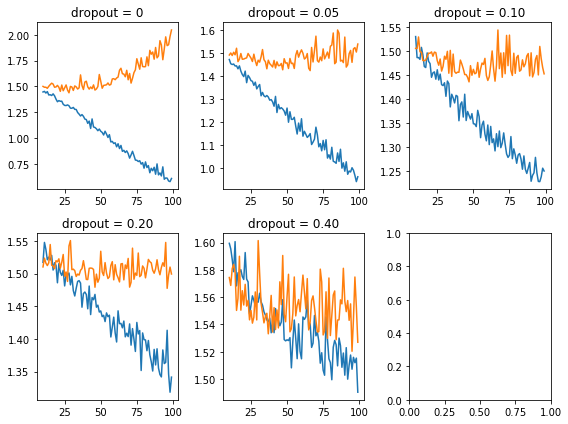

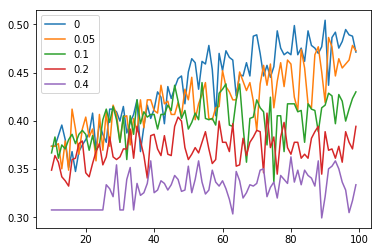

In [8]:
skp = 10
f, axarr = plt.subplots(2, 3, figsize = (8, 6))
axarr[0, 0].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[0][skp:], label = '0')
axarr[0, 0].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[0][skp:], label = '0')
axarr[0, 0].set_title("dropout = 0")

axarr[0, 1].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[1][skp:], label = '0.05')
axarr[0, 1].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[1][skp:], label = '0.05')
axarr[0, 1].set_title("dropout = 0.05")

axarr[0, 2].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[2][skp:], label = '0.1')
axarr[0, 2].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[2][skp:], label = '0.1')
axarr[0, 2].set_title("dropout = 0.10")

axarr[1, 0].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[3][skp:], label = '0.2')
axarr[1, 0].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[3][skp:], label = '0.2')
axarr[1, 0].set_title("dropout = 0.20")

axarr[1, 1].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[4][skp:], label = '0.4')
axarr[1, 1].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[4][skp:], label = '0.4')
axarr[1, 1].set_title("dropout = 0.40")
#f.subplots_adjust(hspace = 0.5)
plt.tight_layout()
plt.show()

plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[0][skp:], label = '0')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[1][skp:], label = '0.05')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[2][skp:], label = '0.1')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[3][skp:], label = '0.2')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[4][skp:], label = '0.4')
plt.legend(loc='best')
plt.show()